In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython import display
from sklearn import metrics

In [2]:
%matplotlib inline
tf.logging.set_verbosity(tf.logging.ERROR)
import warnings; warnings.simplefilter('ignore')

In [3]:
mnist_raw = pd.read_csv("MNIST_data/mnist_train_small.csv", sep=",", header=None)

In [4]:
mnist_raw.tail()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
95,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
mnist_raw.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
mnist_raw.sum(1).divide(255)

0     107.960784
1     121.941176
2      76.262745
3      67.200000
4      91.070588
5     116.090196
6      69.203922
7     140.666667
8      42.647059
9      85.913725
10    111.964706
11     55.901961
12    140.250980
13    111.564706
14     45.580392
...
85    102.203922
86     85.627451
87    109.541176
88    132.839216
89     98.745098
90    116.784314
91    101.737255
92     60.313725
93    115.019608
94    106.984314
95    147.933333
96     71.215686
97    114.831373
98     84.368627
99     50.368627
Length: 100, dtype: float64

In [7]:
def parse_labels_and_features(dataset):
  """Given the data set, pulls out the label column as a series, and pulls out
  the features as a pandas DataFame.  This is a good place to scale or transform
  the features if needed."""

  # The labels are in column zero.
  labels = dataset[0]

  # We'll pick out the remaining columns to use as features.
  #
  # Scale the data to [0,1] by dividing out the max value, 255.
  #
  # Note: DataFrame.loc uses label-location indexing, which includes both ends
  # of ranges.
  features = dataset.loc[:,1:784] / 255

  return labels, features

# Note that this data is given to us in random order, so we can just take head
# and tail to create training and validation splits.
training_labels, training_features = parse_labels_and_features(
  mnist_raw.head(15000))
validation_labels, validation_features = parse_labels_and_features(
  mnist_raw.tail(5000))

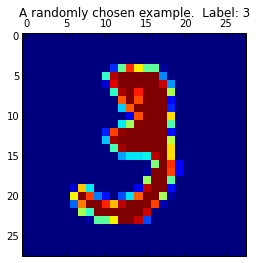

In [8]:
# Show a random example and its corresponding label.
rand_example = np.random.randint(1, 100)
plt.matshow(
  np.matrix(training_features[rand_example:rand_example+1]).reshape(28, 28))
plt.title(
  "A randomly chosen example.  Label: %i" % training_labels[rand_example])
plt.show()

In [9]:
BATCH_SIZE = 100  #@param
LEARNING_RATE = 0.03  #@param
STEPS = 1000  #@param
periods = 10
steps_per_period = STEPS / periods

from sklearn.metrics import confusion_matrix
import seaborn as sns

feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input(
  training_features)
classifier = tf.contrib.learn.LinearClassifier(
  feature_columns=feature_columns,
  n_classes=10,
  optimizer=tf.train.AdagradOptimizer(learning_rate=LEARNING_RATE),
  gradient_clip_norm=5.0
)

training_errors = []
validation_errors = []
print("Training model...")
# Note that we track the model's error using the log loss function.
# This is not to be confused with the loss function that 
# LinearClassifier uses internally for training.
print("LogLoss:")
for period in range (0, periods):
  classifier.fit(
    training_features,
    training_labels,
    steps=steps_per_period,
    batch_size=BATCH_SIZE
  )
  predictions_training = list(classifier.predict_proba(
    training_features, as_iterable=True))
  predictions_validation = list(classifier.predict_proba(
    validation_features, as_iterable=True))

  log_loss_training = metrics.log_loss(
    training_labels, predictions_training)
  log_loss_validation = metrics.log_loss(
    validation_labels, predictions_validation)
  training_errors.append(log_loss_training)
  validation_errors.append(log_loss_validation)
  print("  period %02d : %3.2f" % (period, log_loss_training))

final_predictions = list(classifier.predict(
  validation_features, as_iterable=True))
accuracy_validation = metrics.accuracy_score(
  validation_labels, final_predictions)
print("Final accuracy (on validation data): %0.2f" % accuracy_validation)

Training model...
LogLoss:
  period 00 : 0.19
  period 01 : 0.09
  period 02 : 0.06
  period 03 : 0.04
  period 04 : 0.03
  period 05 : 0.03
  period 06 : 0.02
  period 07 : 0.02
  period 08 : 0.02
  period 09 : 0.02
Final accuracy (on validation data): 1.00


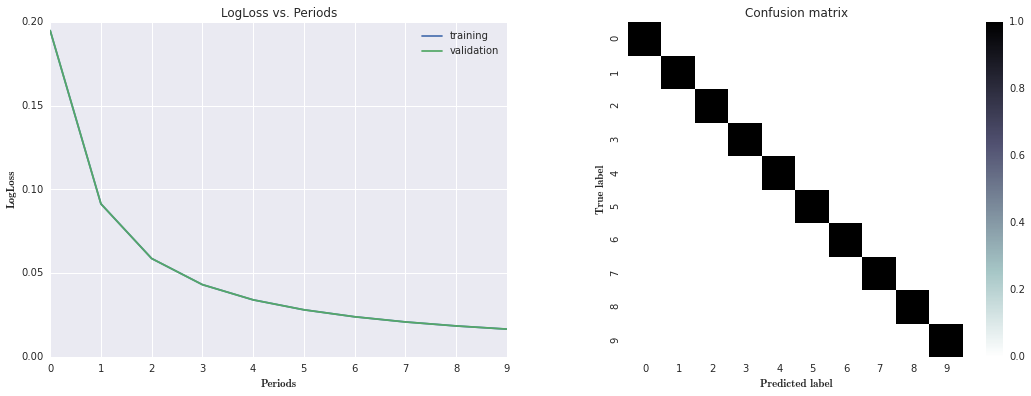

In [10]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)

# Output a graph of loss metrics over periods.
plt.ylabel("LogLoss")
plt.xlabel("Periods")
plt.title("LogLoss vs. Periods")
plt.plot(training_errors, label="training")
plt.plot(validation_errors, label="validation")
plt.legend()

# Compute confusion matrix
plt.subplot(1, 2, 2)
cm = confusion_matrix(validation_labels, final_predictions)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
ax = sns.heatmap(cm_normalized, cmap="bone_r")
ax.set_aspect(1)
plt.title("Confusion matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

In [11]:
BATCH_SIZE = 100
HIDDEN_UNITS = [100, 100]
LEARNING_RATE = 0.05
STEPS = 1000
periods = 5
steps_per_period = STEPS / periods

from sklearn.metrics import confusion_matrix
import seaborn as sns

feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input(
  training_features)
classifier = tf.contrib.learn.DNNClassifier(
  feature_columns=feature_columns,
  n_classes=10,
  hidden_units=HIDDEN_UNITS,
  optimizer=tf.train.AdagradOptimizer(learning_rate=LEARNING_RATE),
  gradient_clip_norm=5.0
)

training_errors = []
validation_errors = []
print "Training model..."
# Note that we track the model's error using the function called
# logistic loss. This is not to be confused with the loss function.
# LinearClassifier defines its own loss function internally.
print "LogLoss:"
for period in range (0, periods):
  classifier.fit(
    training_features,
    training_labels,
    steps=steps_per_period,
    batch_size=BATCH_SIZE
  )
  predictions_training = list(classifier.predict_proba(
    training_features, as_iterable=True))
  predictions_validation = list(classifier.predict_proba(
    validation_features, as_iterable=True))

  log_loss_training = metrics.log_loss(
    training_labels, predictions_training)
  log_loss_validation = metrics.log_loss(
    validation_labels, predictions_validation)
  training_errors.append(log_loss_training)
  validation_errors.append(log_loss_validation)
  print "  period %02d : %3.2f" % (period, log_loss_training)

final_predictions = list(classifier.predict(
  validation_features, as_iterable=True))
accuracy_validation = metrics.accuracy_score(
  validation_labels, final_predictions)
print "Final accuracy (on validation data): %0.2f" % accuracy_validation

Training model...
LogLoss:
  period 00 : 0.01
  period 01 : 0.00
  period 02 : 0.00
  period 03 : 0.00
  period 04 : 0.00
Final accuracy (on validation data): 1.00


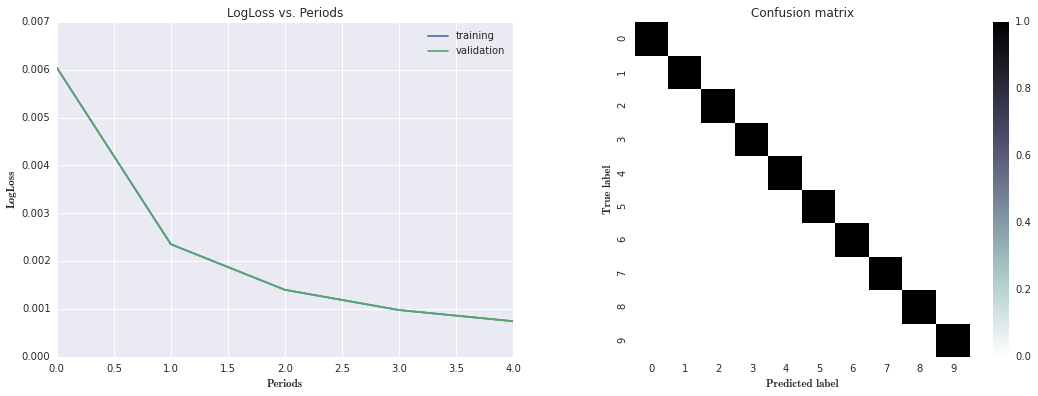

In [12]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)

# Output a graph of loss metrics over periods.
plt.ylabel("LogLoss")
plt.xlabel("Periods")
plt.title("LogLoss vs. Periods")
plt.plot(training_errors, label="training")
plt.plot(validation_errors, label="validation")
plt.legend()

# Compute confusion matrix
plt.subplot(1, 2, 2)
cm = confusion_matrix(validation_labels, final_predictions)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
ax = sns.heatmap(cm_normalized, cmap="bone_r")
ax.set_aspect(1)
plt.title("Confusion matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

weights0 shape: (784, 100)


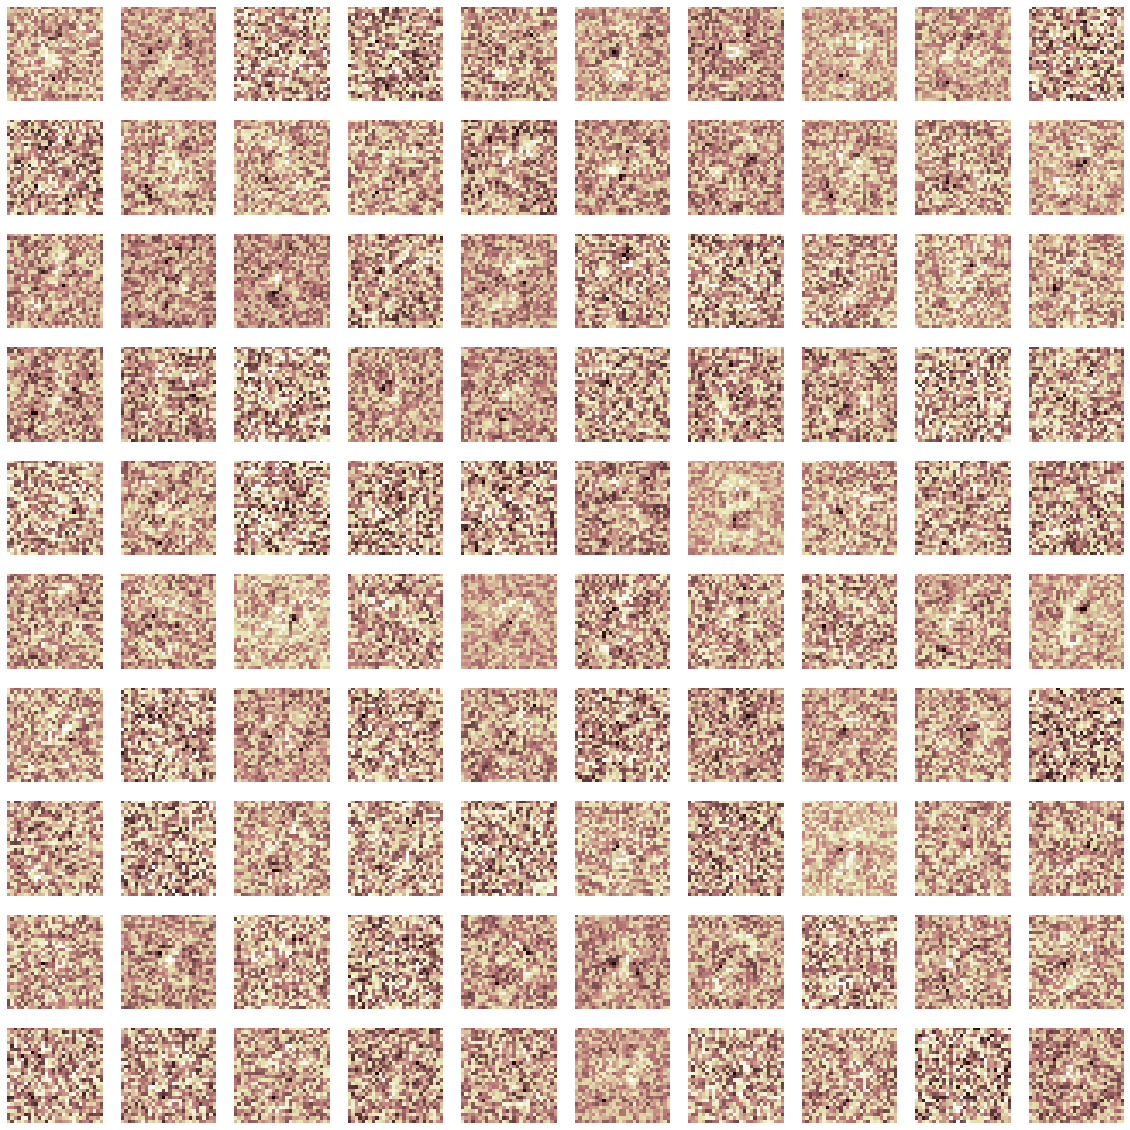

In [13]:
# Note that this cell requires that a TensorFlowDNNClassifier called
# "classifier" has already been trained.
weights0 = classifier.weights_[0]

print("weights0 shape:",)
print(weights0.shape)

num_nodes = weights0.shape[1]
num_rows = int(math.ceil(num_nodes / 10.0))
fig, axes = plt.subplots(num_rows, 10, figsize=(20, 2 * num_rows))
for coef, ax in zip(weights0.T, axes.ravel()):
    ax.matshow(coef.reshape(28, 28), cmap=plt.cm.pink)
    ax.set_xticks(())
    ax.set_yticks(())

plt.show()